# **INTELIGENCIA DEL NEGOCIO / Business Intelligence**
## **ASSIGNMENT A2 - CONVOLUTIONAL NEURAL NETWORKS**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación, etc.
- Recuerda poner nombre a todas las layers de Keras, facilitará mucho las cosas a la hora de depurar errores.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya amplíandolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 19/02/2024**
- **Fecha de Entrega: 25/02/2024**
- **Test: 26/02/2024**


**Autor: Yago Tobio Souto (201802168)**

# Carga de librerías


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

print("TF VERSION: ", tf.__version__)

TF VERSION:  2.15.0


# Carga dataset

Se utilizará un dataset de imágenes sobre señales de tráfico, para la construcción de un clasificador multiclase.

El dataset está contenido en el fichero: **traffic-sign.zip**



In [2]:
# * Clasificador multiclases con un total de 20 clases 
BASE_DIRECTORY = './traffic-sign'
batch_size = 32
img_height = 64
img_width = 64

# Preparación de datasets

Divida el dataset original de señales de tráfico en train, validation y test.

In [3]:
# Label Overview
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
}

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 26610 files belonging to 20 classes.
Using 21288 files for training.
Found 26610 files belonging to 20 classes.
Using 5322 files for validation.


Calculate the number of batches and split the validation dataset for testing: 

In [5]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

*Se debe de considerar el orden que sigue TF para las clases es el de strings, no el de ints, por lo tanto, la clasificación estaría fuera de orden*

In [6]:
# Retrieve class names as identified by TensorFlow
tf_class_names = train_ds.class_names  # e.g., ['0', '1', '10', '11', ..., '2', '3', ...]

# Create a manual mapping to correct the order
# This example assumes tf_class_names is ['0', '1', '10', '11', ..., '2', '3', ...]
# And you want to map them to the correct order based on your 'classes' dictionary
correct_order_mapping = {tf_class_names.index(str(i)): i for i in range(len(classes))}

# Visualizar los datos

Mostrar una muestra representativa de las imágenes contenidas dentro del dataset de entrenamiento.

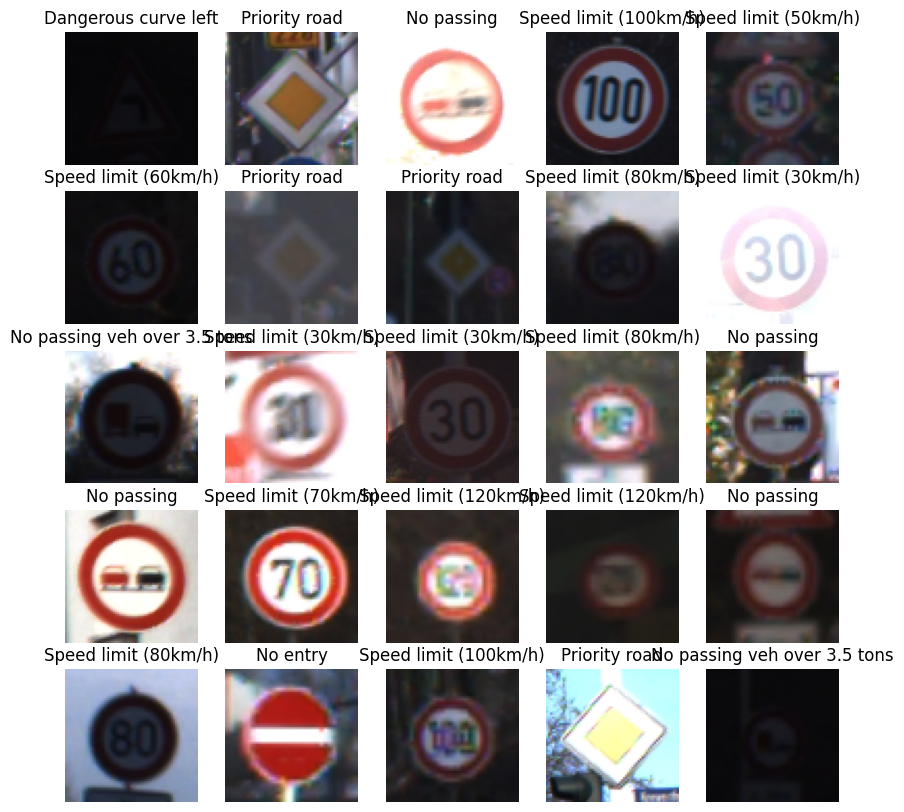

In [7]:
# Now, when plotting or referencing classes, use the mapping to correct the label
def plot_images(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        # Get the correct class label using the mapping
        corrected_label = correct_order_mapping[label_batch[i].numpy()]
        plt.title(classes[corrected_label])
        plt.axis("off")

# Assuming you have already defined train_ds and classes
image_batch, label_batch = next(iter(train_ds))
plot_images(image_batch, label_batch)

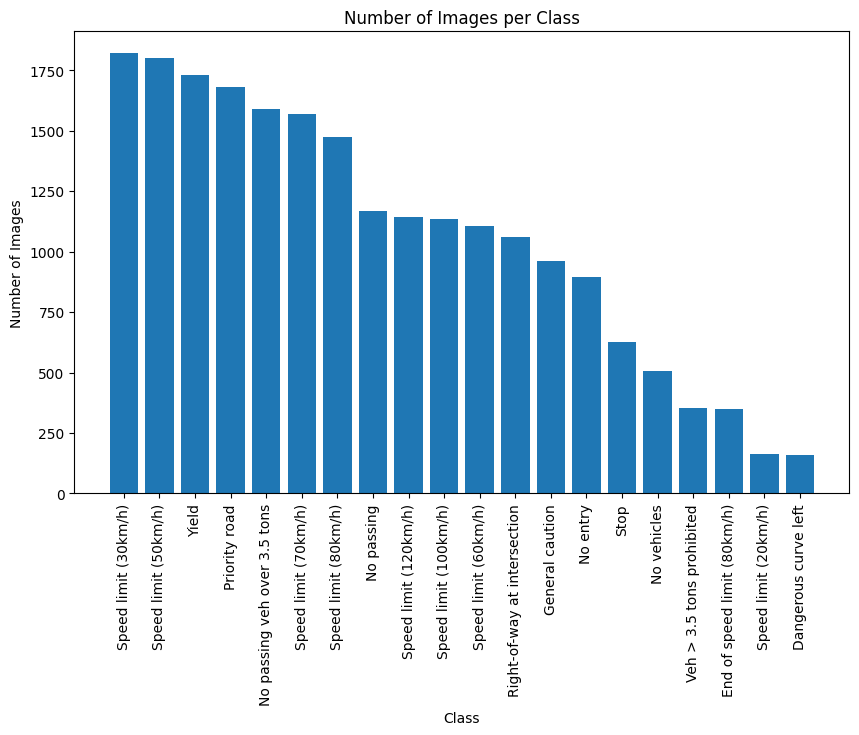

In [8]:
# Assuming train_ds is your training dataset
class_counts = np.zeros(len(classes))

for image_batch, label_batch in train_ds:
    for label in label_batch:
        # Assuming correct_order_mapping correctly maps to class indices
        corrected_label = correct_order_mapping[label.numpy()]
        class_counts[corrected_label] += 1

# Get sorted indices based on counts, from highest to lowest
sorted_indices = np.argsort(class_counts)[::-1]

# Plotting the class counts
plt.figure(figsize=(10, 6))
plt.bar(range(len(classes)), class_counts[sorted_indices], tick_label=[classes[i] for i in sorted_indices])
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

# Activar la cache para la carga de imágenes durante el entrenamiento y la verificación de rendimiento

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Modelo Deep Learning basado en CNN

Construya un modelo CNN para la clasificación de las señales de tráfico a partir del dataset.

Utilice algunas de las técnicas de regularización para evitar el overfitting del modelo siempre que sea necesario.

Augmentation Layer - Helps with image reconstruction, by allowing the decoder to reconstruct different variations of the image

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [11]:
num_classes = len(tf_class_names)
print(num_classes)

20


In [12]:
img_height = 32 
img_width = 32
batch_size = 32
dropout_rate = 0.25
epochs = 20

In [13]:
model = Sequential([
    data_augmentation,
    layers.Input(shape = (64, 64, 3)),
    layers.Rescaling(1./255),
    # * Capa CNN 1 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(), # Normalización para la estabilidad del entrenamiento
    layers.MaxPooling2D((2, 2)), # Reducimos la dimensionalidad espacial
    layers.Dropout(dropout_rate), # Dropout para regularización

    # * Capca CNN 2 - Deep CNN
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # * Capa CNN 3 - Even Deeper CNN
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # * Capa 4 - Aplanar para poder usar el modelo con Deep Neural Net
    layers.Flatten(),

    # * Capa densa
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # *  Capa de salida y activación softmax para clasificación multiclase
    layers.Dense(num_classes, activation = 'softmax')
])

## Compilación del modelo
Compile el modelo con Adam como función de optimización. Elija la función de pérdida acorde con el objetivo del modelo CNN

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Entrenamiento

Seleccionar el tamaño del batch y el número de epochs necesarios.

In [15]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=validation_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', # Monitorear la pérdida de validación
            patience=10, # Número de epochs donde para si no mejora
            restore_best_weights=True # Restaura los pesos a la mejor pérdida de validación
        )
    ]
)

model.summary()

Epoch 1/20


666/666 [==============================] - 42s 62ms/step - loss: 1.6429 - accuracy: 0.5037 - val_loss: 0.7771 - val_accuracy: 0.7865
Epoch 2/20
666/666 [==============================] - 45s 67ms/step - loss: 0.7143 - accuracy: 0.7617 - val_loss: 0.4776 - val_accuracy: 0.8336
Epoch 3/20
666/666 [==============================] - 43s 65ms/step - loss: 0.4924 - accuracy: 0.8384 - val_loss: 0.2860 - val_accuracy: 0.9086
Epoch 4/20
666/666 [==============================] - 46s 68ms/step - loss: 0.3974 - accuracy: 0.8673 - val_loss: 0.2651 - val_accuracy: 0.9231
Epoch 5/20
666/666 [==============================] - 46s 69ms/step - loss: 0.3503 - accuracy: 0.8852 - val_loss: 0.1462 - val_accuracy: 0.9557
Epoch 6/20
666/666 [==============================] - 46s 70ms/step - loss: 0.2882 - accuracy: 0.9050 - val_loss: 0.1537 - val_accuracy: 0.9515
Epoch 7/20
666/666 [==============================] - 47s 70ms/step - loss: 0.2562 - accuracy: 0.9149 - val_loss: 0.1020 - val_accuracy: 0.9728
Epo

## Mostrar los resultados del entrenamiento
El método fit devuelve un objeto de tipo history con las métricas obtenidas durante el entrenamiento. Analice el resultado de ejecutar 'history.history' y dibuje las métricas en las distintas épocas.

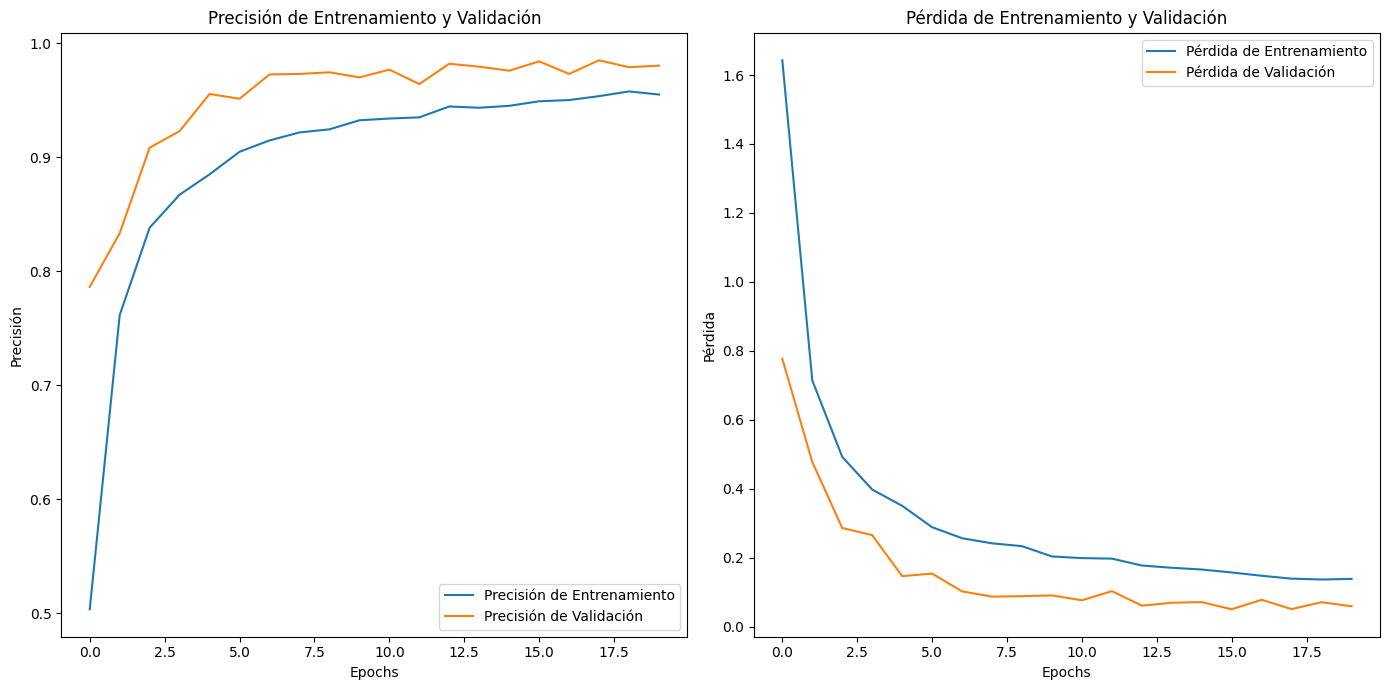

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_len = range(epochs)

# Graficar la precisión del entrenamiento y la validación
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_len, acc, label='Precisión de Entrenamiento')
plt.plot(epochs_len, val_acc, label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida del entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(epochs_len, loss,label='Pérdida de Entrenamiento')
plt.plot(epochs_len, val_loss,label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

## Evaluación

Utilice el dataset de test para verificar el rendimiento del modelo creado.

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nTest accuracy: {test_acc*100}%')

33/33 [==============================] - 1s 17ms/step - loss: 0.0481 - accuracy: 0.9867

Test accuracy: 98.67424368858337%


# Modelo CNN aplicando Transfer Learning

En base al mismo dataset de señales de tráfico, construir un segundo modelo CNN empleando técnicas de Transfer Learning, con el objetivo de mejorar su rendimiento.

Se deberá utilizar como modelo base, cualquiera de los modelos existentes en el TF Hub (https://www.kaggle.com/models)

Nota: evaluar las dimensiones del modelo base, ya que si es demasiado grande, podría llegar a existir un problema de falta de recursos dentro de Colab.


In [18]:
# Definir parámetros para la carga de imágenes
batch_size = 32
IMG_SIZE = 96

In [32]:
# Cargar el dataset de entrenamiento
train_dataset_transfer = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size)

# Cargar el dataset de validación
validation_dataset_transfer = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size)

Found 26610 files belonging to 20 classes.
Using 21288 files for training.
Found 26610 files belonging to 20 classes.
Using 5322 files for validation.


In [33]:
val_batches = tf.data.experimental.cardinality(validation_dataset_transfer)
test_dataset = validation_dataset_transfer.take(val_batches // 5)
validation_dataset_transfer = validation_dataset_transfer.skip(val_batches // 5)

In [34]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,  # No incluir la capa de clasificación superior
    weights='imagenet', 
    pooling='avg'
)  # Preentrenado en ImageNet

base_model.trainable = False

model_transfer = Sequential([
    data_augmentation,  # * Añadir augmentation layer en los datos
    Rescaling(1./127.5, offset=-1, input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # * Añadir una capa de reescalado
    base_model, 
    Flatten(),

    Dense(1024, activation = 'relu'), 
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),  
    Dense(len(class_counts), activation='softmax')
])

## Compilación del modelo

In [35]:
model_transfer.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Entrenamiento

In [36]:
history = model_transfer.fit(
    train_dataset_transfer,
    validation_data=validation_dataset_transfer,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', # Monitorear la pérdida de validación
            patience=10, # Número de epochs donde para si no mejora
            restore_best_weights=True # Restaura los pesos a la mejor pérdida de validación
        )
    ]
)

model_transfer.summary()

Epoch 1/20


666/666 [==============================] - 61s 90ms/step - loss: 1.0549 - accuracy: 0.6381 - val_loss: 0.7459 - val_accuracy: 0.7450
Epoch 2/20
666/666 [==============================] - 56s 84ms/step - loss: 0.6803 - accuracy: 0.7568 - val_loss: 0.5841 - val_accuracy: 0.7965
Epoch 3/20
666/666 [==============================] - 53s 79ms/step - loss: 0.5760 - accuracy: 0.7952 - val_loss: 0.5458 - val_accuracy: 0.8085
Epoch 4/20
666/666 [==============================] - 47s 70ms/step - loss: 0.5001 - accuracy: 0.8202 - val_loss: 0.4744 - val_accuracy: 0.8291
Epoch 5/20
666/666 [==============================] - 47s 70ms/step - loss: 0.4561 - accuracy: 0.8393 - val_loss: 0.4903 - val_accuracy: 0.8291
Epoch 6/20
666/666 [==============================] - 47s 71ms/step - loss: 0.4158 - accuracy: 0.8546 - val_loss: 0.4446 - val_accuracy: 0.8441
Epoch 7/20
666/666 [==============================] - 46s 69ms/step - loss: 0.3903 - accuracy: 0.8642 - val_loss: 0.3698 - val_accuracy: 0.8694
Epo

## Mostrar los resultados del entrenamiento

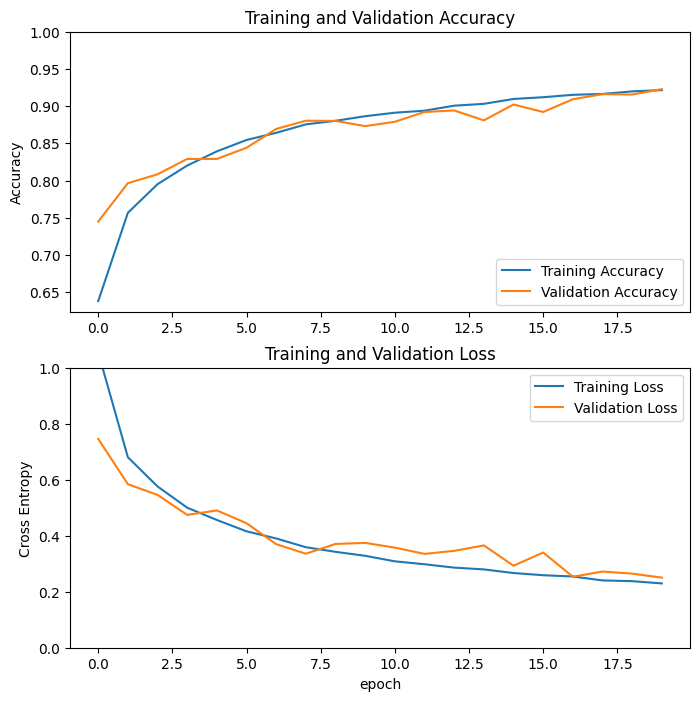

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluación

In [41]:
## Evaluación
test_loss, test_acc = model_transfer.evaluate(validation_dataset_transfer)
print(f'\nTest accuracy: {test_acc*100}%')

134/134 [==============================] - 7s 51ms/step - loss: 0.2492 - accuracy: 0.9233

Test accuracy: 92.33474135398865%


# Conclusiones del estudio

Detallar las principales conclusiones extraidas sobre la construcción del modelo CNN, la aplicación de las técnicas de transfer learning, y la comparativa entre ambos.

A través de esta práctica, hemos desarollado modelos de redes neuronales convolucionales, mediante aprendizaje _no supervisado_ con el objetivo de detectar los patrones de distintas señas de trafico. 

## CNN vs. Transfer Learning

### Modelo CNN 
* La precisión durante el entrenamiento y la validación mejoró consistentemente con cada epoch adicional, indicando una convergencia efectiva. Gracias a la implementación de una estrategia de parada temprana (early stopping), se determinó que el número óptimo de epochs rondaba los 18.

* La aplicación de Data Augmentation contribuyó significativamente a evitar el sobreajuste, introduciendo variabilidad en los datos de entrenamiento y haciéndolos más generalizables.

* La aplicación de Data Augmentation contribuyó significativamente a evitar el sobreajuste, introduciendo variabilidad en los datos de entrenamiento y haciéndolos más generalizables.

* Este modelo logró una impresionante precisión del 98.67%.


### CNN con Transfer Learning
* Las características de desempeño son similares a las del modelo CNN estándar, aunque se notó una ligera intersección entre los conjuntos de entrenamiento y validación, señal de un posible sobreajuste.

* La precisión obtenida fue del 92.33%, indicando una disminución respecto al modelo CNN puro.

* A pesar de esta reducción en la precisión, los modelos que utilizan Transfer Learning son reconocidos por su alta eficiencia. Sorprendentemente, el tiempo de procesamiento fue casi idéntico al del modelo CNN estándar, resaltando la importancia de considerar la complejidad del modelo al elegir entre estas dos opciones.


-----

Verificar porque el código de abajo no funcionó: 
* Es probablemente porque esta práctica no tiene nada que ver con los autoencoders, es todo con CNN's. 

In [ ]:
class CustomAutoencoder(keras.Model): 
    def __init__(self, dropout_rate): 
        super(CustomAutoencoder, self).__init__()
        self.dropout_rate = dropout_rate
        
        # Encoder: 
        self.encoder = tf.keras.Sequential([
            layers.Input(shape = (64, 64, 3)), # ? - Ya que tenemos 3 canales
            # * CNN - Layer 1
            layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'), 
            layers.BatchNormalization(), 
            layers.MaxPooling2D((2,2)), 
            layers.Dropout(self.dropout_rate), 
            # * CNN - Layer 2 - Aumentamos numero de filtros para la profundidad
            layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout_rate),
            # * CNN - Layer 3 - Aumentamos numero de filtros para la profundidad
            layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout_rate),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Reshape((8, 8, 128)),
            layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Dropout(self.dropout_rate),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Dropout(self.dropout_rate),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Dropout(self.dropout_rate),
            layers.BatchNormalization(),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'),
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded